# Instacart Market Basket Analysis

In [1]:
# !pip install wordcloud cufflinks pyspark

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
from scipy import stats
from apyori import apriori
from collections import Counter
from itertools import combinations

from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from pyspark.ml.fpm import FPGrowth
import gc                         
gc.enable()

In [5]:
aisles = pd.read_csv("data/aisles.csv")
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [6]:
departments = pd.read_csv("data/departments.csv")
departments.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [8]:
orders = pd.read_csv("data/orders.csv")
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [9]:
products = pd.read_csv("data/products.csv")
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [10]:
order_products_prior = pd.read_csv("data/order_products__prior.csv")
order_products_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [11]:
order_products_train = pd.read_csv("data/order_products__train.csv")
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [12]:
order_products = pd.concat([order_products_prior, order_products_train])

order_products.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [13]:
orders = pd.read_csv("data/orders.csv")

orders_test = orders[orders['eval_set'] == 'test']

In [15]:
df = pd.merge(orders, order_products, on='order_id')
df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


In [18]:
products = pd.read_csv("data/products.csv")

merged_info = pd.merge(df, products, on='product_id')
merged_info = pd.merge(merged_info, aisles, on='aisle_id')
merged_info = pd.merge(merged_info, departments, on='department_id')
merged_info.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages
5,3367565,1,prior,6,2,7,19.0,196,1,1,Soda,77,7,soft drinks,beverages
6,550135,1,prior,7,1,9,20.0,196,1,1,Soda,77,7,soft drinks,beverages
7,3108588,1,prior,8,1,14,14.0,196,2,1,Soda,77,7,soft drinks,beverages
8,2295261,1,prior,9,1,16,0.0,196,4,1,Soda,77,7,soft drinks,beverages
9,2550362,1,prior,10,4,8,30.0,196,1,1,Soda,77,7,soft drinks,beverages


# EDA

### Plotting the data of products

<AxesSubplot:>

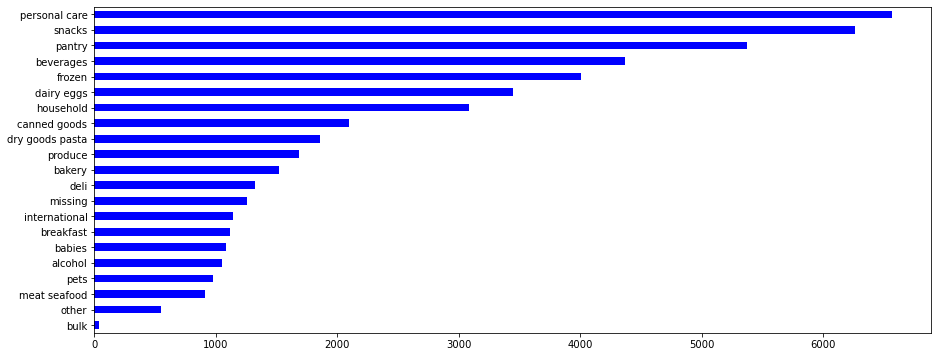

In [19]:
dept_products = pd.merge(left=products, right=departments, on='department_id')

plt.figure(figsize=(15,6))

dept_products['department'].value_counts().sort_values(ascending=True).plot(kind='barh',color='blue')

### Word Cloud

Product Combinations : 1581702 


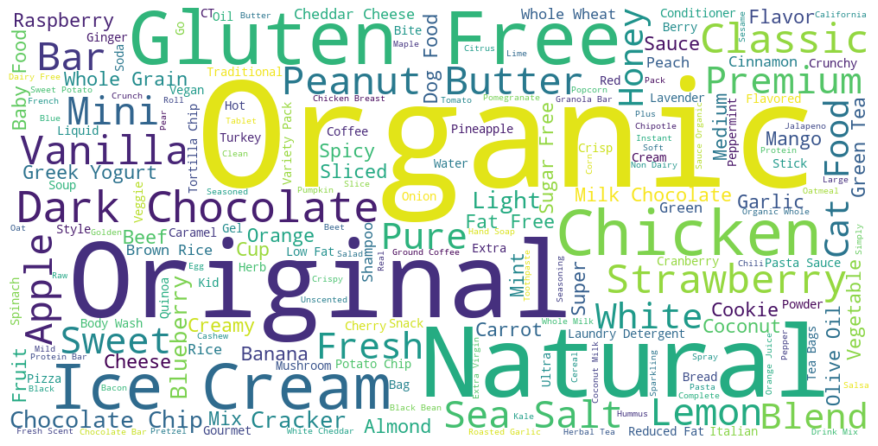

In [22]:
text = " ".join(topic for topic in dept_products.product_name.astype(str))
print ("Product Combinations : {} ".format(len(text)))

wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (15,6)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Word clouds makes it simpler to understand the density of products in a dataset

<AxesSubplot:xlabel='reordered', ylabel='count'>

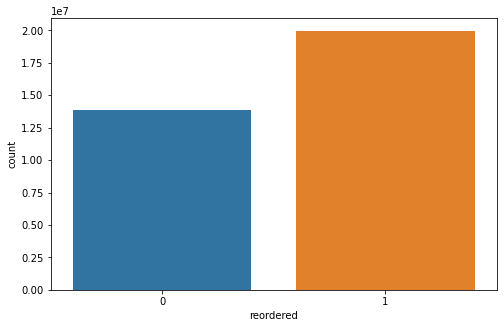

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='reordered',data=merged_info)

In [24]:
merged_info['days_since_prior_order'].dropna(inplace= True)

<AxesSubplot:>

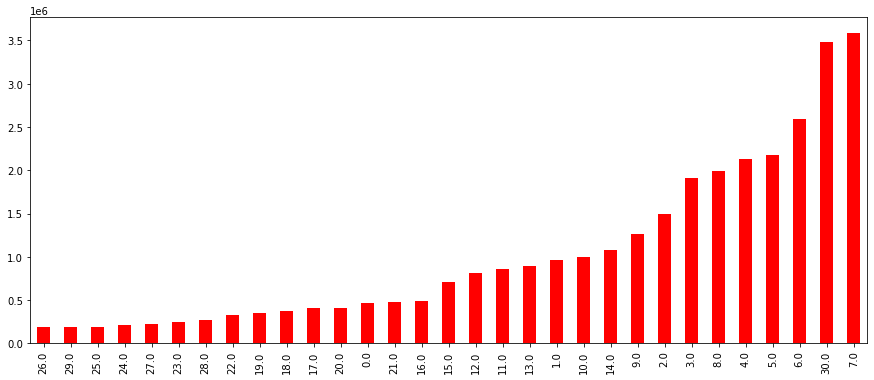

In [26]:
merged_info['days_since_prior_order'].value_counts().sort_values(ascending= True).plot(kind='bar',color='red')

From the data, a customer would re order a product monthly or weekly

***Most reordered and least reordered product***

In [27]:
aisle_change = merged_info.groupby(['aisle', 'department'])['reordered'].mean().to_frame().reset_index()

aisle_change.sort_values('reordered', ascending=False)[:5]\
.append(pd.Series('...', index=aisle_change.columns), ignore_index=True)\
.append(aisle_change.sort_values('reordered', ascending=False)[-5:], ignore_index=True)

,aisle,department,reordered
0,milk,dairy eggs,0.781812
1,water seltzer sparkling water,beverages,0.72993
2,fresh fruits,produce,0.718823
3,eggs,dairy eggs,0.706359
4,soy lactosefree,dairy eggs,0.692361
5,...,...,...
6,beauty,personal care,0.212858
7,first aid,personal care,0.195864
8,kitchen supplies,household,0.194802
9,baking supplies decor,pantry,0.167595


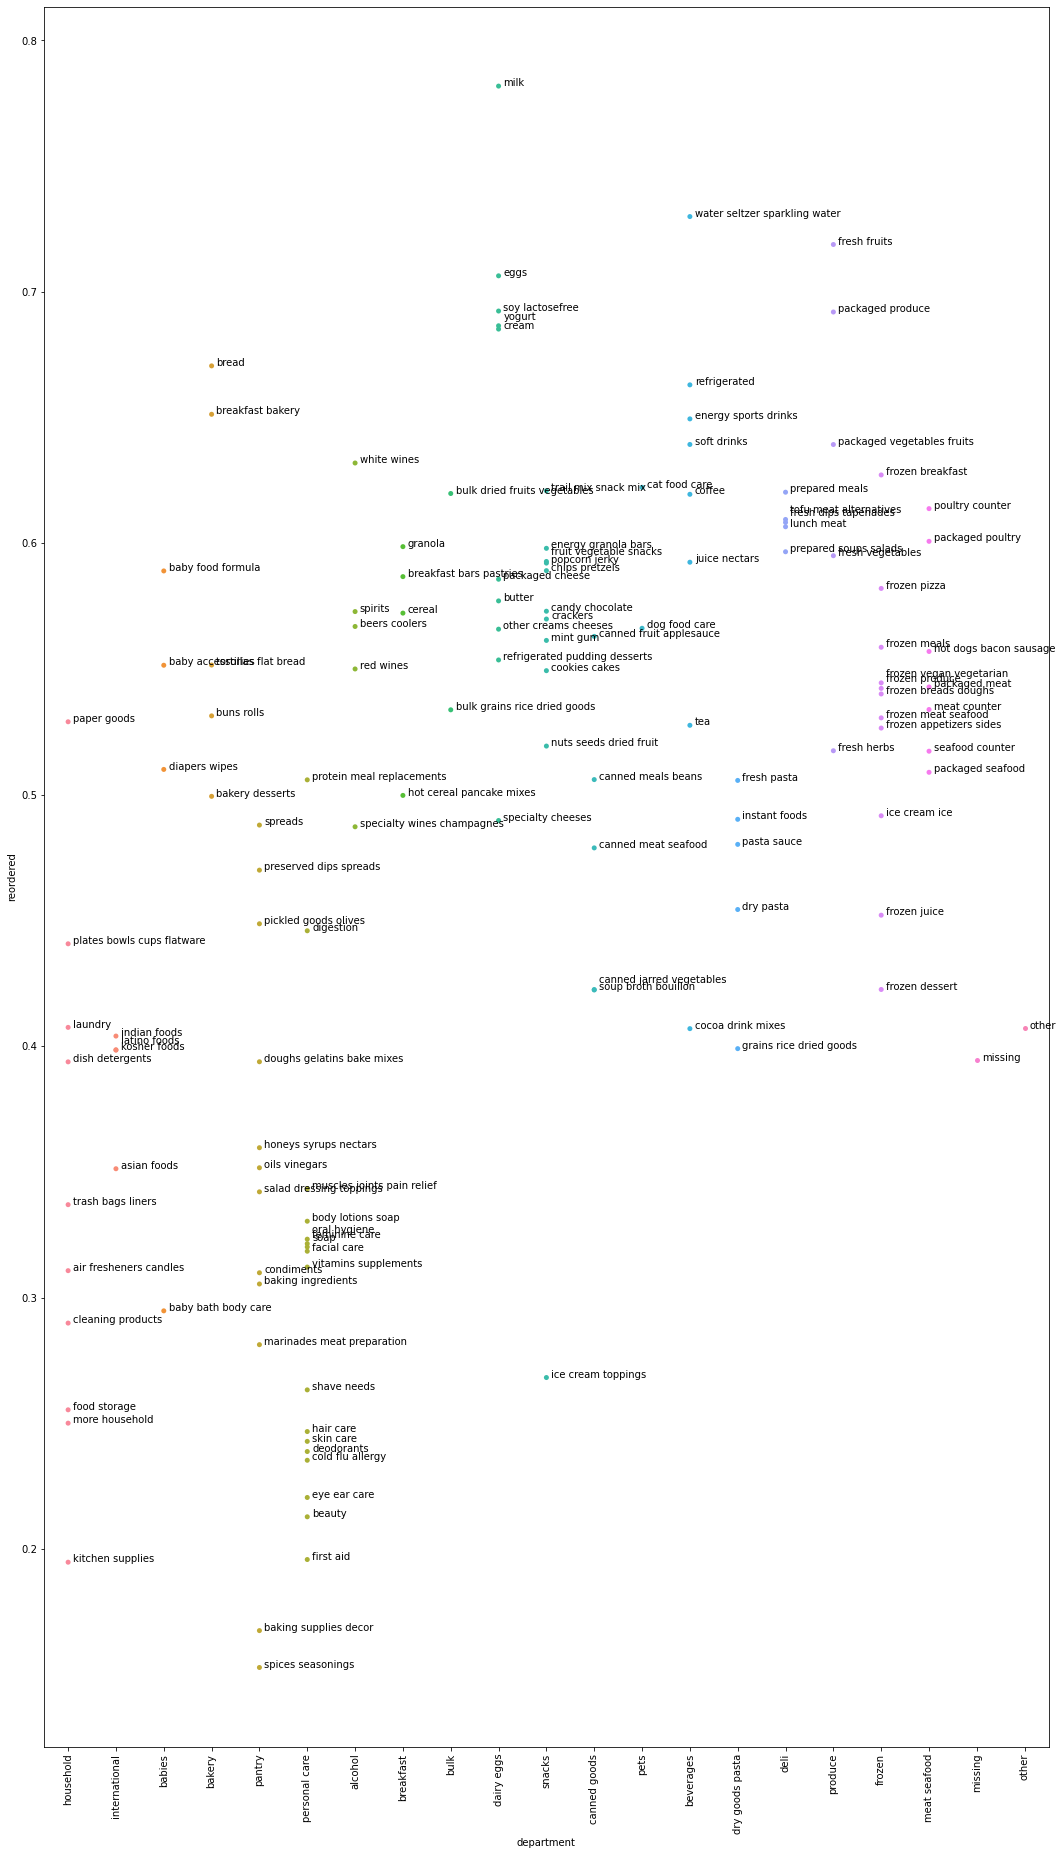

In [29]:

plt.figure(figsize=(18,32))

ax = sns.stripplot(x='department', y='reordered', data=aisle_change, jitter=False)

plt.xticks(rotation='vertical')

dep_cat = aisle_change['department'].unique().tolist()

for i in range(aisle_change.shape[0]):
    if (aisle_change[aisle_change['department'] == aisle_change['department'].iloc[i]]['reordered'] \
        - aisle_change['reordered'].iloc[i]).between(-0.0025, 0, inclusive=False).any(): 
        ax.annotate(aisle_change['aisle'].iloc[i],
                    xy=(dep_cat.index(aisle_change['department'].iloc[i]), aisle_change['reordered'].iloc[i]),
                    xytext=(dep_cat.index(aisle_change['department'].iloc[i])+0.1, aisle_change['reordered'].iloc[i]+0.0025))
    else:
        ax.annotate(aisle_change['aisle'].iloc[i],
                    xy=(dep_cat.index(aisle_change['department'].iloc[i]), aisle_change['reordered'].iloc[i]),
                    xytext=(dep_cat.index(aisle_change['department'].iloc[i])+0.1, aisle_change['reordered'].iloc[i]))

plt.show()

# Train and test data

In [31]:
order_products_pr = pd.merge(order_products_prior, orders, how="inner", on="order_id")
order_products_pr.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
5,2,17794,6,1,202279,prior,3,5,9,8.0
6,2,40141,7,1,202279,prior,3,5,9,8.0
7,2,1819,8,1,202279,prior,3,5,9,8.0
8,2,43668,9,0,202279,prior,3,5,9,8.0
9,3,33754,1,1,205970,prior,16,5,17,12.0


In [32]:
user = order_products_pr.groupby('user_id')['order_number'].max().to_frame('u_total_orders').reset_index()
user.head(10)

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4
5,6,3
6,7,20
7,8,3
8,9,3
9,10,5


In [33]:
u_reorder = order_products_pr.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio').reset_index()
u_reorder.head(10)

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378
5,6,0.142857
6,7,0.669903
7,8,0.265306
8,9,0.236842
9,10,0.342657


In [34]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head(10)

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378
5,6,3,0.142857
6,7,20,0.669903
7,8,3,0.265306
8,9,3,0.236842
9,10,5,0.342657


In [35]:
prd = order_products_pr.groupby('product_id')['order_id'].count().to_frame('p_total_purchases').reset_index()
prd.head(10)

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15
5,6,8
6,7,30
7,8,165
8,9,156
9,10,2572


In [36]:
p_reorder = order_products_pr.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head(10)

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030
5,9,0.525641
6,10,0.506998
7,11,0.567308
8,12,0.512195
9,18,0.598540


In [37]:
prd = prd.merge(p_reorder, on='product_id', how='left')
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)

del p_reorder
gc.collect()

prd.head(10)

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000
5,6,8,0.000000
6,7,30,0.000000
7,8,165,0.503030
8,9,156,0.525641
9,10,2572,0.506998


In [38]:
uxp = order_products_pr.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought').reset_index()
uxp.head(10)

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3
5,1,13176,2
6,1,14084,1
7,1,17122,1
8,1,25133,8
9,1,26088,2


In [39]:
prior_grouped_df = order_products_pr.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(order_products_pr, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head(10)

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0
5,59897,1934,1
6,59897,6383,1
7,59897,39046,0
8,59897,48171,0
9,59897,33506,1


In [40]:
prior_df_agg = order_products_pr.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head(10)

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2
5,1,13176,2,1
6,1,14084,1,0
7,1,17122,1,0
8,1,25133,8,7
9,1,26088,2,1


In [41]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head(10)

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0
5,1,13176,2,1,NaN
6,1,14084,1,0,NaN
7,1,17122,1,0,NaN
8,1,25133,8,7,1.0
9,1,26088,2,1,NaN


In [42]:
orders = orders.drop(["order_number"],axis=1)

train_df = pd.read_csv("data/order_products__train.csv", usecols=["order_id"])

train_df.head(10)

,order_id
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,36
9,36


In [43]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head(10)

,order_id
0,1
1,36
2,38
3,96
4,98
5,112
6,170
7,218
8,226
9,349


In [44]:
train_df = pd.merge(train_df, orders, how="inner", on="order_id")

train_df = train_df.loc[:,["order_id", "user_id"]]
train_df.head(10)

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463
5,112,125030
6,170,182389
7,218,98711
8,226,51011
9,349,156353


In [45]:
test_df = pd.read_csv("data/sample_submission.csv", usecols=["order_id"])
test_df = pd.merge(test_df, orders, how="inner", on="order_id")
test_df = test_df.loc[:,["order_id", "user_id"]]
test_df.head(10)

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581
5,313,113359
6,353,173814
7,386,55492
8,414,120775
9,418,33565


In [46]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN
5,1,112108,24852,1,0,NaN
6,1,112108,30881,2,1,1.0
7,1,112108,42001,1,0,NaN
8,1,112108,43633,2,1,1.0
9,1,112108,44359,2,1,NaN


In [47]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
test_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0
5,17,36855,13535,1,0,NaN
6,17,36855,15613,1,0,NaN
7,17,36855,16965,1,0,NaN
8,17,36855,18288,1,0,NaN
9,17,36855,21463,2,1,1.0


In [48]:
products = pd.read_csv("data/products.csv", usecols=["product_id", "aisle_id", "department_id"])

products.head(10)

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13
5,6,11,11
6,7,98,7
7,8,116,1
8,9,120,16
9,10,115,7


In [49]:
train_df = pd.merge(train_df, products, how="inner", on="product_id")
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19
5,18711,116422,2067,6,5,NaN,3,19
6,19097,3298,2067,18,17,NaN,3,19
7,19794,33842,2067,26,25,NaN,3,19
8,20407,159092,2067,3,2,1.0,3,19
9,22151,85190,2067,1,0,NaN,3,19


In [50]:
test_df = pd.merge(test_df, products, how="inner", on="product_id")
test_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21
5,1559724,185709,1283,2,1,1.0,100,21
6,1575667,124428,1283,1,0,NaN,100,21
7,2290723,155269,1283,1,0,NaN,100,21
8,2829393,19117,1283,1,0,NaN,100,21
9,17,36855,6291,1,0,NaN,121,14


In [51]:
train_y_df = pd.read_csv("data/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])

train_y_df.head(10)

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1
5,1,13176,0
6,1,47209,0
7,1,22035,1
8,36,39612,0
9,36,19660,1


In [52]:
train_y_df = pd.merge(train_y_df, orders, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered
0,1,112108,2067,1,0,NaN,3,19,0.0
1,96,17227,2067,1,0,NaN,3,19,0.0
2,3243,206024,2067,1,0,NaN,3,19,0.0
3,12950,11456,2067,1,0,0.0,3,19,0.0
4,17683,177724,2067,1,0,NaN,3,19,0.0
5,18711,116422,2067,6,5,NaN,3,19,0.0
6,19097,3298,2067,18,17,NaN,3,19,0.0
7,19794,33842,2067,26,25,NaN,3,19,1.0
8,20407,159092,2067,3,2,1.0,3,19,1.0
9,22151,85190,2067,1,0,NaN,3,19,0.0


In [53]:
train_df = train_df.merge(user, on='user_id', how='left')
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586
5,18711,116422,2067,6,5,NaN,3,19,0.0,76,0.766734
6,19097,3298,2067,18,17,NaN,3,19,0.0,43,0.821570
7,19794,33842,2067,26,25,NaN,3,19,1.0,54,0.847810
8,20407,159092,2067,3,2,1.0,3,19,1.0,9,0.528455
9,22151,85190,2067,1,0,NaN,3,19,0.0,42,0.651601


In [54]:
train_df = train_df.merge(prd, on='product_id', how='left')
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571,3138,0.606119
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558,3138,0.606119
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896,3138,0.606119
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619,3138,0.606119
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586,3138,0.606119
5,18711,116422,2067,6,5,NaN,3,19,0.0,76,0.766734,3138,0.606119
6,19097,3298,2067,18,17,NaN,3,19,0.0,43,0.821570,3138,0.606119
7,19794,33842,2067,26,25,NaN,3,19,1.0,54,0.847810,3138,0.606119
8,20407,159092,2067,3,2,1.0,3,19,1.0,9,0.528455,3138,0.606119
9,22151,85190,2067,1,0,NaN,3,19,0.0,42,0.651601,3138,0.606119


In [55]:
train_df = train_df.merge(uxp, on=['user_id', 'product_id'], how='left')
train_df.head(10)

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,uxp_total_bought
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571,3138,0.606119,1
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558,3138,0.606119,1
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896,3138,0.606119,1
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619,3138,0.606119,1
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586,3138,0.606119,1
5,18711,116422,2067,6,5,NaN,3,19,0.0,76,0.766734,3138,0.606119,6
6,19097,3298,2067,18,17,NaN,3,19,0.0,43,0.821570,3138,0.606119,18
7,19794,33842,2067,26,25,NaN,3,19,1.0,54,0.847810,3138,0.606119,26
8,20407,159092,2067,3,2,1.0,3,19,1.0,9,0.528455,3138,0.606119,3
9,22151,85190,2067,1,0,NaN,3,19,0.0,42,0.651601,3138,0.606119,1


In [56]:
print('Training Data: ', train_df.shape)

Training Data:  (8474661, 14)


# Models

In [57]:
new_train_data = train_df

print("New train data: ",new_train_data.shape)
X=new_train_data.drop(['reordered','u_total_orders'],axis=1)
X.head(10)

New train data:  (8474661, 14)


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,u_reordered_ratio,p_total_purchases,p_reorder_ratio,uxp_total_bought
0,1,112108,2067,1,0,NaN,3,19,0.428571,3138,0.606119,1
1,96,17227,2067,1,0,NaN,3,19,0.232558,3138,0.606119,1
2,3243,206024,2067,1,0,NaN,3,19,0.620896,3138,0.606119,1
3,12950,11456,2067,1,0,0.0,3,19,0.547619,3138,0.606119,1
4,17683,177724,2067,1,0,NaN,3,19,0.608586,3138,0.606119,1
5,18711,116422,2067,6,5,NaN,3,19,0.766734,3138,0.606119,6
6,19097,3298,2067,18,17,NaN,3,19,0.821570,3138,0.606119,18
7,19794,33842,2067,26,25,NaN,3,19,0.847810,3138,0.606119,26
8,20407,159092,2067,3,2,1.0,3,19,0.528455,3138,0.606119,3
9,22151,85190,2067,1,0,NaN,3,19,0.651601,3138,0.606119,1


In [58]:
Y = new_train_data['reordered']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [60]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)

In [61]:
%%time

clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

clfrf.fit(X_train, y_train)

predictions = clfrf.predict(X_test)

print("Randomforest classifier accuracy: ",accuracy_score(predictions, y_test))

/Users/vineetbatthina/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Users/vineetbatthina/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning:

invalid value encountered in true_divide



Randomforest classifier accuracy:  0.9047288548861687
CPU times: user 8min 42s, sys: 5.84 s, total: 8min 48s
Wall time: 8min 50s


Text(0.5, 0, 'Important Features - Using Random Forest')

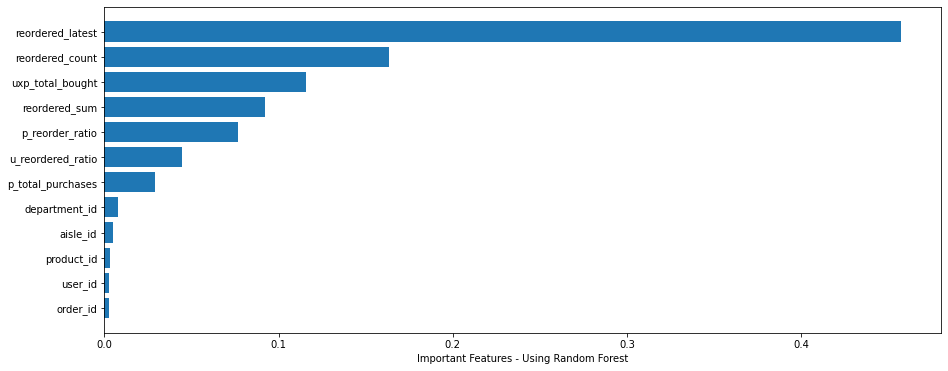

In [62]:
sorted_idx = clfrf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clfrf.feature_importances_[sorted_idx])
plt.xlabel("Important Features - Using Random Forest")

# Association Rule mining

In [63]:
products = pd.read_csv("data/products.csv")
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}

In [64]:
order_products = order_products_prior.iloc[0:4000000, :]
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
3999995,422066,36603,5,0
3999996,422066,20502,6,1
3999997,422066,26251,7,1
3999998,422066,16959,8,0


**Apriori Algorithm**

In [66]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Initiating...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print( 'Generated Rules: {}'.format(len(apriori_df)))

    return apriori_df

In [67]:
%%time
rules = association_rules(order_products, min_support = 0.01)
display(rules.head(20))

Initiating...
Supports...
Combinations and supports...
Dataframe...
Generated Rules: 13


,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042123,0.082295,0.010395,0.246766,2.998576
1,Organic Fuji Apple,Banana,0.027774,0.147230,0.010576,0.380801,2.586433
2,Organic Raspberries,Bag of Organic Bananas,0.042123,0.118016,0.012375,0.293772,2.489255
3,Organic Hass Avocado,Bag of Organic Bananas,0.066126,0.118016,0.019117,0.289098,2.449649
4,Cucumber Kirby,Banana,0.030195,0.147230,0.010044,0.332637,2.259300
5,Organic Avocado,Banana,0.054675,0.147230,0.016426,0.300424,2.040508
6,Organic Strawberries,Bag of Organic Bananas,0.082295,0.118016,0.019175,0.233004,1.974342
7,Strawberries,Banana,0.044267,0.147230,0.012854,0.290370,1.972220
8,Large Lemon,Banana,0.047652,0.147230,0.012637,0.265192,1.801204
9,Organic Baby Spinach,Bag of Organic Bananas,0.075295,0.118016,0.015664,0.208033,1.762751


CPU times: user 35.4 s, sys: 1.85 s, total: 37.2 s
Wall time: 37.4 s


Most frequently bought food : Banana.

Observed pattern : Healthy foods are brought together more and it makes sense

In [68]:
rules = association_rules(order_products, min_support = 0.002, max_length=3)
with pd.option_context('display.max_colwidth', None):
    display(rules.head(20))

Initiating...
Supports...
Combinations and supports...
Dataframe...
Generated Rules: 217


,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005125,0.006046,0.002321,0.452756,74.883976
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.006046,0.005125,0.002321,0.383813,74.883976
2,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.006046,0.005521,0.002086,0.345015,62.486258
3,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005521,0.006046,0.002086,0.377798,62.486258
4,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% with Strawberry Lowfat Greek Strained Yogurt,0.006586,0.009255,0.002855,0.433550,46.847309
5,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total 2% Lowfat Greek Strained Yogurt With Blueberry,0.009255,0.006586,0.002855,0.308531,46.847309
6,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009255,0.006061,0.002507,0.270919,44.696931
7,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained Yogurt,0.006061,0.009255,0.002507,0.413650,44.696931
8,Yellow Bell Pepper,Orange Bell Pepper,0.007769,0.012107,0.002126,0.273701,22.606245
9,Frozen Organic Wild Blueberries,Organic Whole Strawberries,0.009383,0.009673,0.002013,0.214516,22.176213


Higher Lift would mean that the probability of the products being purchased together is higher. In this case, the data show that customers tend to take more than one flavour of yogurt and water

**FPGrowth Algorithm**

In [71]:
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.master("local[*]").getOrCreate()


In [72]:
order_products = pd.merge(order_products, products, on='product_id')
order_products = order_products[['order_id', 'product_name']]
order_products

,order_id,product_name
0,2,Organic Egg Whites
1,26,Organic Egg Whites
2,120,Organic Egg Whites
3,327,Organic Egg Whites
4,390,Organic Egg Whites
...,...,...
3999995,421756,California Vegetables
3999996,421792,Antifungal Liquid Athletes Foot Spray
3999997,421796,"8\"" Pecan Pie"
3999998,421880,"Panty Liners, Normal, Perfume Free"


In [73]:
sparkdata = spark.createDataFrame(order_products)
sparkdata

DataFrame[order_id: bigint, product_name: string]

In [74]:
basketdata = sparkdata.groupBy("order_id").agg(F.collect_list("product_name"))
basketdata

DataFrame[order_id: bigint, collect_list(product_name): array<string>]

In [75]:
%%time
fpGrowth = FPGrowth(itemsCol="collect_list(product_name)", minSupport=0.01, minConfidence=0.01)
model = fpGrowth.fit(basketdata)


CPU times: user 12.5 ms, sys: 11.2 ms, total: 23.7 ms
Wall time: 18.3 s


In [77]:
items = model.freqItemsets
rules = model.associationRules
transformed = model.transform(basketdata)

In [78]:
items_pdf = items.select("*").toPandas()
items_pdf.head(10)

,items,freq
0,[Organic Broccoli Florets],4073
1,[Organic Reduced Fat 2% Milk],5846
2,[Organic Reduced Fat Milk],4441
3,[Organic Ginger Root],6464
4,[Raspberries],7156
5,[Broccoli Crown],5170
6,[Organic Black Beans],4718
7,[Carrots],9069
8,[Organic Small Bunch Celery],8311
9,[Organic Whole Milk],16899


In [80]:
rules_pdf = rules.select("*").toPandas()
rules_pdf.head(10)

,antecedent,consequent,confidence,lift,support
0,[Banana],[Organic Strawberries],0.118708,1.442480,0.017477
1,[Banana],[Organic Baby Spinach],0.109234,1.450750,0.016083
2,[Banana],[Organic Avocado],0.111564,2.040508,0.016426
3,[Banana],[Cucumber Kirby],0.068220,2.259300,0.010044
4,[Banana],[Large Lemon],0.085832,1.801204,0.012637
5,[Banana],[Organic Fuji Apple],0.071835,2.586433,0.010576
6,[Banana],[Strawberries],0.087305,1.972220,0.012854
7,[Banana],[Limes],0.068032,1.553382,0.010016
8,[Cucumber Kirby],[Banana],0.332637,2.259300,0.010044
9,[Bag of Organic Bananas],[Organic Raspberries],0.104856,2.489255,0.012375


In [81]:
transformed_pdf = transformed.select("*").toPandas()
with pd.option_context('display.max_colwidth', None):
  display(transformed_pdf.head(10))

,order_id,collect_list(product_name),prediction
0,7,"[Orange Juice, Pineapple Chunks]",[]
1,19,"[Unsweetened Almondmilk, Organic Baby Carrots, Organic Whole White Mushrooms]",[]
2,22,"[Asparagus, 2% Reduced Fat Milk, Banana, Butter Top White Bread, Iceberg Lettuce, Broccoli Florets, Large Grade AA Eggs, Provolone Slices, Vine Ripe Tomatoes, Boneless And Skinless Chicken Breast, Deli Fresh Honey Smoked Turkey Breast, 98% Fat Free, Gluten Free, Presliced Everything Bagels, Cream Cheese, Sandwich Bags]","[Organic Strawberries, Organic Baby Spinach, Organic Avocado, Cucumber Kirby, Large Lemon, Organic Fuji Apple, Strawberries, Limes]"
3,26,"[Organic Unsweetened Almond Milk, Red Grapefruit, Boneless Skinless Chicken Breasts, Berry Medley, Organic Baby Spinach, Banana, Organic Avocado, Organic Egg Whites]","[Organic Strawberries, Cucumber Kirby, Large Lemon, Organic Fuji Apple, Strawberries, Limes, Bag of Organic Bananas, Organic Hass Avocado]"
4,29,"[Raspberries, Smartwater, Baby Cucumbers, Sinfully Sweet Campari Tomatoes, Bag of Organic Bananas]","[Organic Raspberries, Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado]"
5,50,"[Pure Granulated Cane Sugar, Mango Yoghurt, Peach Yoghurt, All Natural Gluten Free Probiotic Pineapple Yoghurt, Organic Fresh Basil, Shredded Parmesan, French Vanilla Ice Cream]",[]
6,54,"[Banana, Philadelphia Original Cream Cheese, Nilla Wafers, Instant French Vanilla Pudding & Pie Filling, Mixed Berries Wildly Nutritious Signature Blends, Original Whipped Topping, Sliced Peaches]","[Organic Strawberries, Organic Baby Spinach, Organic Avocado, Cucumber Kirby, Large Lemon, Organic Fuji Apple, Strawberries, Limes]"
7,57,"[Organic Baby Spinach, Organic Hass Avocado, Organic Strawberries, Authentic French Brioche, Ultra-Purified Water, Organic Bartlett Pear, Organic Large Extra Fancy Fuji Apple]","[Bag of Organic Bananas, Banana, Organic Raspberries]"
8,65,"[Organic 1% Lowfat Milk, Organic 2% Reduced Fat Milk, Soy Sauce]",[]
9,77,"[Red Vine Tomato, Large Lemon, Organic Yellow Onion, Organic Cucumber, Lentil Chips, Aged White Cheddar, Organic Gluten Free Maple Buckwheat Flakes, Organic Vanilla Soymilk, Sparkling Mineral Water, Red Peppers, Yellow Bell Pepper, Apple Honeycrisp Organic, Orange Bell Pepper, Beyond Beef Beefy Crumble, California Sourdough Bread, Hummus, Hope, Original Recipe, Sea Salt Pita Chips, Seven Grain Crispy Tenders, Organic Tomato Basil Pasta Sauce, Marinara Pasta Sauce, Organic Extra Large Grade AA Brown Eggs, Veggie Burger, Quarter Pound]",[Banana]
